In [1]:
from os import getcwd
from os.path import join, abspath

from copy import deepcopy
from joblib import Parallel, delayed, parallel_backend
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from tqdm import tqdm

from src.models.estimator import RFClassifier, relu
from src.models.weights import V1_weights, classical_weights
from src.data.load_dataset import load_kmnist

In [2]:
data_dir = abspath(join(getcwd(), '../../'))

In [3]:
# load dataset
train_loader, val_loader, test_loader = load_kmnist()
train, test = train_loader.dataset.dataset, test_loader.dataset
train, train_labels = train.data.numpy(), train.targets.numpy()
X_test, y_test = test.data.numpy(), test.targets.numpy()

X_train, X_val, y_train, y_val = train_test_split(train, train_labels, train_size=50, 
                                                  stratify=train_labels, random_state=42)

# params
h = 1000
bias = 0
nonlinearity = relu
scale = 1
center = None
size, frequency = 8, 3
kwargs = {'size':size, 'spatial_freq': frequency, 'center': None, 'scale': scale}
cv = 3

# ridge params 
alphas = np.logspace(-7, 7, 15)

In [4]:
accuracy = np.zeros((len(alphas), cv))
for i, a in enumerate(tqdm(alphas)):
    clf = LinearSVC(C=a, tol=1e-4, max_iter=1000)
    v1_clf = RFClassifier(h, V1_weights, bias, nonlinearity, deepcopy(clf), kwargs)
    scores = cross_val_score(v1_clf, X_train, y_train, cv=cv, verbose=0)
    accuracy[i] = scores

100%|██████████| 15/15 [00:17<00:00,  1.20s/it]


[[1.00000000e-07 4.81617647e-01]
 [1.00000000e-06 5.01225490e-01]
 [1.00000000e-05 5.20833333e-01]
 [1.00000000e-04 4.81617647e-01]
 [1.00000000e-03 5.01225490e-01]
 [1.00000000e-02 4.62009804e-01]
 [1.00000000e-01 5.01225490e-01]
 [1.00000000e+00 5.01225490e-01]
 [1.00000000e+01 5.01225490e-01]
 [1.00000000e+02 5.60049020e-01]
 [1.00000000e+03 5.01225490e-01]
 [1.00000000e+04 5.00000000e-01]
 [1.00000000e+05 5.40441176e-01]
 [1.00000000e+06 5.01225490e-01]
 [1.00000000e+07 5.40441176e-01]]
0.01


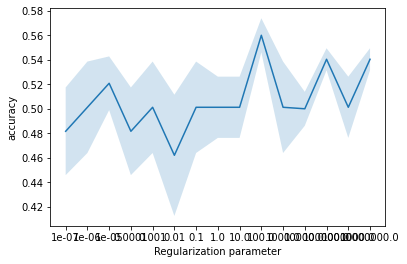

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
mean = 1 - np.mean(accuracy, axis=1)
std = np.std(accuracy, axis=1) / np.sqrt(cv)
plt.semilogx(alphas, mean)
plt.fill_between(alphas, mean - std, mean + std, alpha=0.2)
ax.set_xticks(alphas)
ax.set_xticklabels(alphas)
plt.xlabel('Regularization parameter')
plt.ylabel('accuracy')
print(np.array(list(zip(alphas, mean))))

a = alphas[np.argmin(mean)]
print(a)

In [6]:
n_jobs = 3
num_trials = 2
num_neurons = [1, 50, 100, 250, 500, 1000, 3000, 5000]
kwargs = {'size':5, 'spatial_freq':2, 'center':None, 'scale':scale}
clf = LinearSVC(C=a, tol=1e-4, max_iter=1000)
test_V1 = {'hidden_size': [], 'mean': [], 'std_err': []}

for n in tqdm(num_neurons):
    classifiers = [RFClassifier(n, V1_weights, bias, nonlinearity, deepcopy(clf), kwargs) for i in range(num_trials)]
    with parallel_backend('threading', n_jobs=n_jobs):
        Parallel()(delayed(RFclf.fit)(X_train, y_train) for RFclf in classifiers)
        test_accuracy = [RFclf.score(X_test, y_test) for RFclf in classifiers]
    
    test_V1['mean'].append(np.mean(test_accuracy))
    test_V1['std_err'].append(np.std(test_accuracy) / np.sqrt(num_trials))
    test_V1['hidden_size'].append(n)

  0%|          | 0/8 [00:00<?, ?it/s]/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
 12%|█▎        | 1/8 [00:00<00:05,  1.28it/s]/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
100%|██████████| 8/8 [00:11<00:00,  1.47s/it]


In [7]:
n_jobs = 3
num_trials = 2
num_neurons = [1, 50, 100, 250, 500, 1000, 3000, 5000]
kwargs = {'scale':scale}
clf = LinearSVC(C=a, tol=1e-4, max_iter=1000)
test_classical = {'hidden_size': [], 'mean': [], 'std_err': []}

for n in tqdm(num_neurons):
    classifiers = [RFClassifier(n, classical_weights, bias, nonlinearity, deepcopy(clf), kwargs) for i in range(num_trials)]
    with parallel_backend('threading', n_jobs=n_jobs):
        Parallel()(delayed(RFclf.fit)(X_train, y_train) for RFclf in classifiers)
        test_accuracy = [RFclf.score(X_test, y_test) for RFclf in classifiers]
        
    test_classical['mean'].append(np.mean(test_accuracy))
    test_classical['std_err'].append(np.std(test_accuracy) / np.sqrt(num_trials))
    test_classical['hidden_size'].append(n)

  0%|          | 0/8 [00:00<?, ?it/s]/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/bpandey/anaconda3/envs/random_features/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


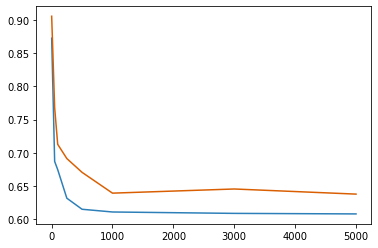

In [10]:
fig = plt.figure()
plt.plot(test_V1['hidden_size'], 1 - np.array(test_V1['mean']), c='#2c7fb8')
plt.plot(test_classical['hidden_size'], 1 - np.array(test_classical['mean']), c='#d95f02')
# plt.xlim([0, 1000])

In [9]:
1 - np.array(test_V1['mean'])[-1], 1 - np.array(test_classical['mean'])[-1]

(0.60795, 0.63775)